<center><h1>DeepGlobe Road Extraction - EDA</h1></center>

## 1. Business Problem

### 1.1. Description

* In disaster zones, especially in developing countries, maps and accessibility information are crucial for crisis response. We would like to pose the challenge of automatically extracting roads and street networks from satellite images.

* For details about other DeepGlobe challenges and the workshop: <a href="deepglobe.org">deepglobe.org</a>.

### 1.2. Source/Useful Links

* Some research papers about the problem statement.

    * https://openaccess.thecvf.com/content_cvpr_2018_workshops/papers/w4/Demir_DeepGlobe_2018_A_CVPR_2018_paper.pdf
    * https://www.cs.toronto.edu/~urtasun/publications/mattyus_etal_iccv17.pdf
    * https://arxiv.org/pdf/1908.08223.pdf
    * https://www.kaggle.com/vanvalkenberg/road-maps-from-aerial-images
    * https://www.kaggle.com/balraj98/road-extraction-from-satellite-images-deeplabv3

## 2. Deep Learning Problem Formulation

### 2.1. Data Overview

* Source → https://www.kaggle.com/balraj98/deepglobe-road-extraction-dataset
* In total we have `14796` images. Out of which
    - `6226` → training satellite images
    - `6226` → training mask images
    - `1243` → validation satellite images
    - `1101` → test satellite images
* Validation data and test data do not contain respective mask images. This is something we need to predict.

### 2.2. Mapping the Problem w.r.t DL Problem

#### 2.2.1 Type of DL Problem

* There are `2` classes (basically a binary image segmentation task).
* This is a part of computer vision task.

#### 2.2.2. Performance Metric

* Source → https://towardsdatascience.com/iou-a-better-detection-evaluation-metric-45a511185be1

* Metric(s)
    - IOU Score
    - Accuracy

#### 2.2.3. Data Download

* I have already downloaded the data from Kaggle and stored the zip file in my drive.
* Data can be downloaded easily by using Kaggle API.

## 3. Exploratory Data Analysis

### 3.1. `import` Packages

In [ ]:
! pip install patool --quiet

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import patoolib
import os
import pandas as pd
import cv2 as cv

from tqdm import tqdm
from matplotlib import pyplot as plt

### 3.2. Data Reading

Loading the original data

In [ ]:
# ! gdown --id 1Cf00v1ZEy0zK2hJFV0-Wgf6l0eOpM0Sw

In [ ]:
# patoolib.extract_archive(archive='/content/DeepGlobe.zip', outdir='/content/DeepGlobe')

In [ ]:
file_path = '/content/DeepGlobe/metadata.csv'
df = pd.read_csv(filepath_or_buffer=file_path)

In [ ]:
df.shape

(8570, 4)

In [ ]:
df.head()

image_id  split        sat_image_path              mask_path
0    100034  train  train/100034_sat.jpg  train/100034_mask.png
1    100081  train  train/100081_sat.jpg  train/100081_mask.png
2    100129  train  train/100129_sat.jpg  train/100129_mask.png
3    100703  train  train/100703_sat.jpg  train/100703_mask.png
4    100712  train  train/100712_sat.jpg  train/100712_mask.png

In [ ]:
df.isnull().sum()

image_id             0
split                0
sat_image_path       0
mask_path         2344
dtype: int64

In [ ]:
data_path = '/content/DeepGlobe/'

* Trainind data contains both satellite images and masked images.
* Validation data and test data do not contain the masked images.

In [ ]:
train_data = df[df['split'] == 'train']
valid_data = df[df['split'] == 'valid']
test_data = df[df['split'] == 'test']

In [ ]:
train_data.shape

(6226, 4)

In [ ]:
valid_data.shape

(1243, 4)

In [ ]:
test_data.shape

(1101, 4)

* There are around `14796` files.

In [ ]:
(6226 * 2) + 1243 + 1101

14796

### 3.3. Image Displaying

The size of each image is `(1024, 1024)`.

In [ ]:
def display_images(df, split_val, split_col='split', data_path='/content/DeepGlobe/', limit=5, show_plot=False):
    # split_val → 'train' or 'valid' or 'test'

    split_data = df[df[split_col] == split_val][:limit]

    if (split_val == 'train'):
        sat_images = [data_path + i for i in split_data['sat_image_path'].to_list()]
        mask_images = [data_path + i for i in split_data['mask_path'].to_list()]

        sat_titles = [i.split('/')[-1] for i in sat_images]
        mask_titles = [i.split('/')[-1] for i in mask_images]

        for i in list(range(len(sat_images))):
            # satellite image reading in RGB
            simage = cv.imread(sat_images[i])
            simage = cv.cvtColor(simage, cv.COLOR_BGR2RGB)

            # masked image
            mimage = cv.imread(mask_images[i], cv.IMREAD_UNCHANGED)

            if show_plot:
                plt.figure(figsize=(10, 10))

                plt.subplot(1, 2, 1)
                plt.title(sat_titles[i])
                plt.axis("off")
                plt.imshow(simage)

                plt.subplot(1, 2, 2)
                plt.title(mask_titles[i])
                plt.axis("off")
                plt.imshow(mimage)

                plt.show()
        
        return None
    
    # else part
    sat_images = [data_path + i for i in split_data['sat_image_path'].to_list()]
    sat_titles = [i.split('/')[-1] for i in sat_images]

    for i in list(range(len(sat_images))):
        # satellite image reading in RGB
        simage = cv.imread(sat_images[i])
        simage = cv.cvtColor(simage, cv.COLOR_BGR2RGB)

        if show_plot:
            plt.figure(figsize=(5, 5))
            plt.title(sat_titles[i])
            plt.axis("off")
            plt.imshow(simage)
            plt.show()
    
    return None

#### 3.3.1. Train Images

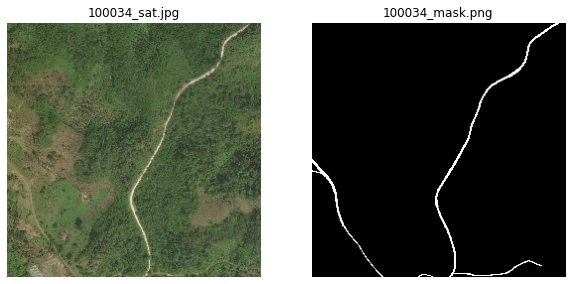

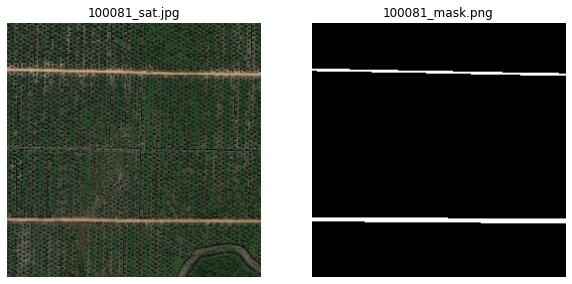

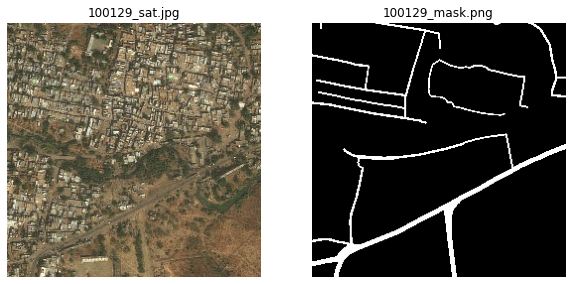

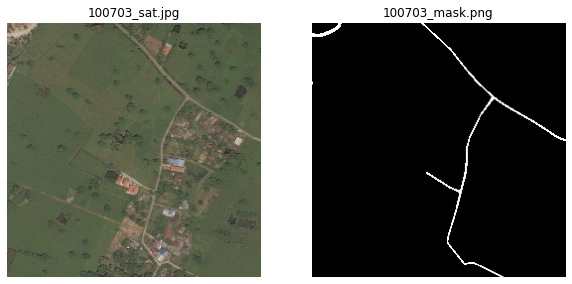

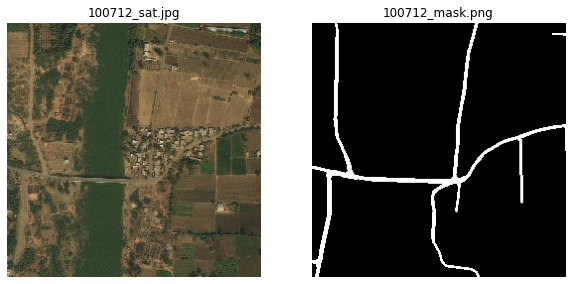

In [ ]:
display_images(df=df, split_val='train', show_plot=True)

#### 3.3.2. Valid Images

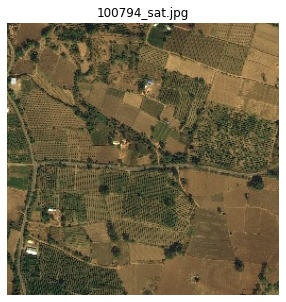

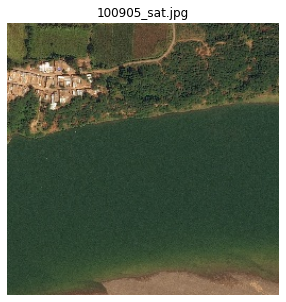

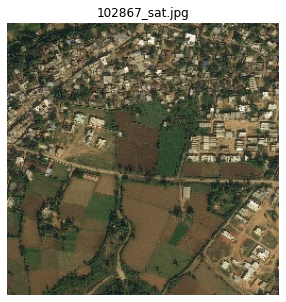

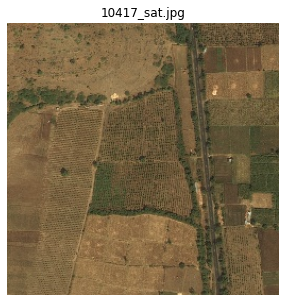

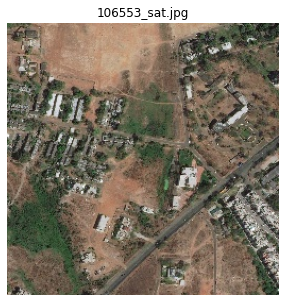

In [ ]:
display_images(df=df, split_val='valid', show_plot=True)

#### 3.3.3. Test Images

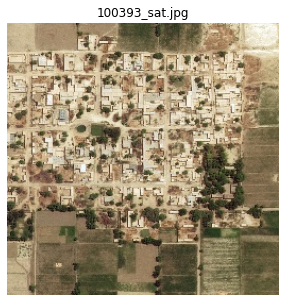

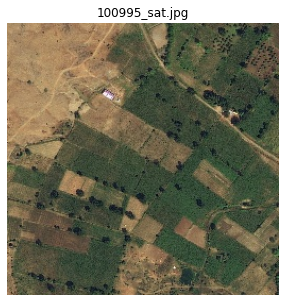

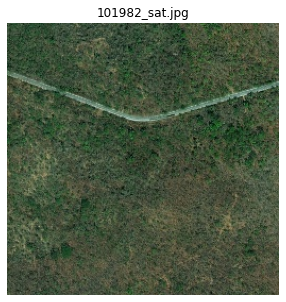

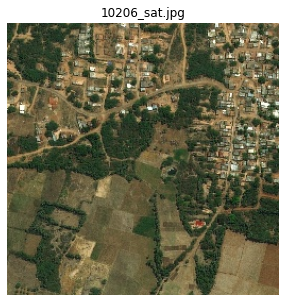

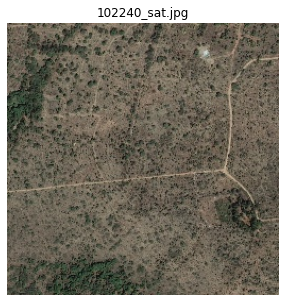

In [ ]:
display_images(df=df, split_val='test', show_plot=True)

### 3.4. Binarize Mask Images

* The values of the mask image may not be pure `0` and `255`. When converting to labels, please binarize them at threshold `128`.

* The labels are not perfect due to the cost for annotating segmentation mask, specially in rural regions.
    - In addition, the data providers intentionally didn't annotate small roads within farmlands.

In [ ]:
def cross_check_masks(df, split_col='split', split_val='train', limit=5, data_path='/content/DeepGlobe/', show_plot=False, save_fig=False):
    split_data = df[df[split_col] == split_val][:limit]

    mask_images = [data_path + i for i in split_data['mask_path'].to_list()]
    mask_titles = [i.split('/')[-1] for i in mask_images]

    for i in list(range(len(mask_images))):
        # masked image
        mimage = cv.imread(mask_images[i])
        mimage = cv.cvtColor(mimage, cv.COLOR_BGR2RGB)

        # image binarization
        th, mimage_bin = cv.threshold(src=mimage, thresh=128, maxval=255, type=cv.THRESH_BINARY)
    
        if show_plot:
            plt.figure(figsize=(10, 10))

            plt.subplot(1, 2, 1)
            plt.title(mask_titles[i])
            plt.axis("off")
            plt.imshow(mimage)

            plt.subplot(1, 2, 2)
            plt.title(mask_titles[i] + '_bin')
            plt.axis("off")
            plt.imshow(mimage_bin)

            plt.show()
        
        if save_fig:
            cv.imwrite(data_path + 'train/' + mask_titles[i], mimage_bin)

    return None

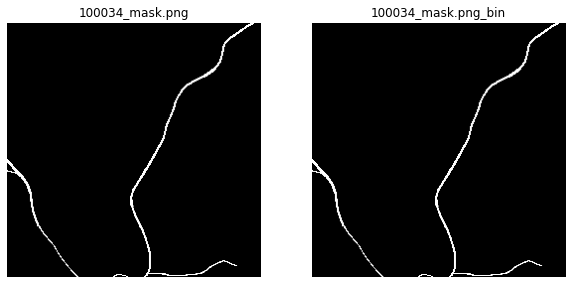

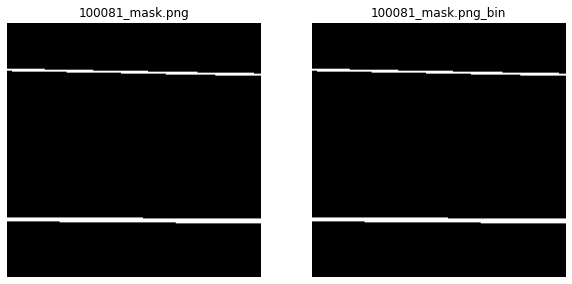

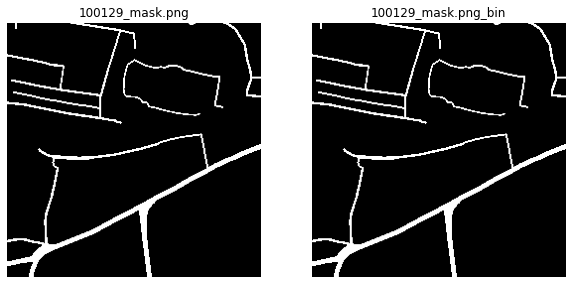

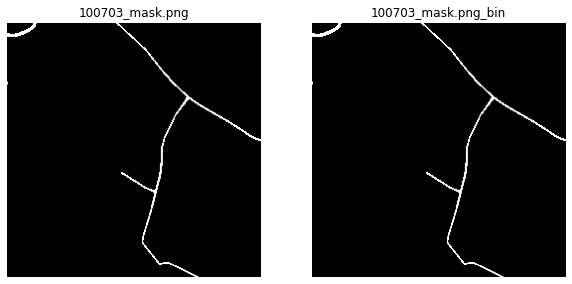

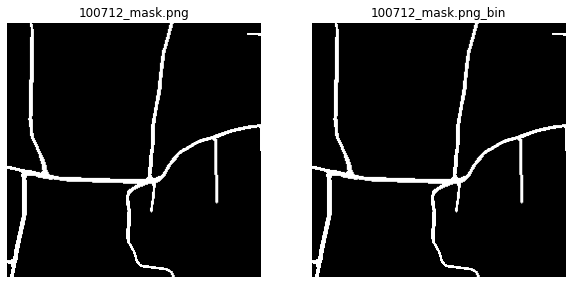

In [ ]:
cross_check_masks(df=df, show_plot=True, save_fig=False)

#### 3.4.1. Saving the binarized data of masks in drive

In [ ]:
# import shutil
# shutil.make_archive('DeepGlobe_Bin', 'zip', '/content/DeepGlobe/')

In [ ]:
# ! mv /content/DeepGlobe_Bin.zip /content/drive/MyDrive/AAIC/SCS-2/deep_globe_road_extraction/DeepGlobe_Bin.zip

### 3.5. Load Binarized Data

In [ ]:
# ! gdown --id 1TnmywRERXwgqI45OkR8WoNYxlglzNXSy

In [ ]:
# patoolib.extract_archive(archive='/content/DeepGlobe_Bin.zip', outdir='/content/DeepGlobe_Bin')

### 3.6. Resizing Images

The ideal shape that is taken here is `(256, 256)`.

In [ ]:
def resize_images_in_archive(df, split_val, split_col='split', data_path='/content/DeepGlobe_Bin/', size=256, save_fig=False):
    # split_val → 'train' or 'valid' or 'test'

    split_data = df[df[split_col] == split_val]

    if (split_val == 'train'):
        sat_images = [data_path + i for i in split_data['sat_image_path'].to_list()]
        mask_images = [data_path + i for i in split_data['mask_path'].to_list()]

        sat_titles = [i.split('/')[-1] for i in sat_images]
        mask_titles = [i.split('/')[-1] for i in mask_images]

        print('Saving the train images')
        for i in tqdm(list(range(len(sat_images)))):
            # satellite image reading in RGB
            simage = cv.imread(sat_images[i])
            simage = cv.resize(simage, (size, size), interpolation=cv.INTER_NEAREST)

            # masked image
            mimage = cv.imread(mask_images[i])
            mimage = cv.resize(mimage, (size, size), interpolation=cv.INTER_NEAREST)

            if save_fig:
                cv.imwrite(data_path + 'train/' + sat_titles[i], simage)
                cv.imwrite(data_path + 'train/' + mask_titles[i], mimage)
        
        return None
    
    # else part
    sat_images = [data_path + i for i in split_data['sat_image_path'].to_list()]
    sat_titles = [i.split('/')[-1] for i in sat_images]

    print('Saving the {} images'.format(split_val))
    for i in tqdm(list(range(len(sat_images)))):
        # satellite image reading in RGB
        simage = cv.imread(sat_images[i])
        simage = cv.resize(simage, (size, size), interpolation=cv.INTER_NEAREST)

        if save_fig:
            cv.imwrite(data_path + split_val + '/' + sat_titles[i], simage)
    
    return None

#### 3.6.1. Train Images Resizing

In [ ]:
# resize_images_in_archive(df=df, split_val='train', save_fig=True)

#### 3.6.2. Valid Images Resizing

In [ ]:
# resize_images_in_archive(df=df, split_val='valid', save_fig=True)

#### 3.6.3. Test Images Resizing

In [ ]:
# resize_images_in_archive(df=df, split_val='test', save_fig=True)

#### 3.6.4. Saving the re-sized data in drive

In [ ]:
# import shutil
# shutil.make_archive('DeepGlobe_256', 'zip', '/content/DeepGlobe_Bin/')

In [ ]:
# ! mv /content/DeepGlobe_256.zip /content/drive/MyDrive/AAIC/SCS-2/deep_globe_road_extraction/DeepGlobe_256.zip

### 3.7. Load Re-sized Archive

In [ ]:
# ! gdown --id 1--tT1cPD-vbbPXFKrbFvxjsDEzV81B1T

In [ ]:
# patoolib.extract_archive(archive='/content/DeepGlobe_256.zip', outdir='/content/DeepGlobe_256')

### 3.8. Image Displaying

#### 3.8.1. Train Images

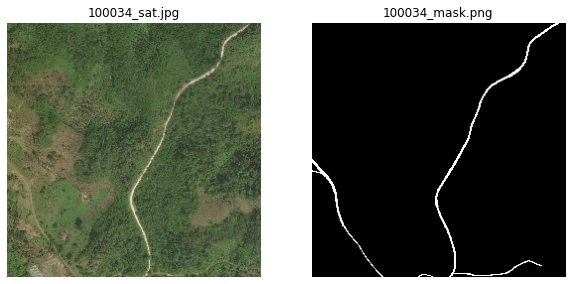

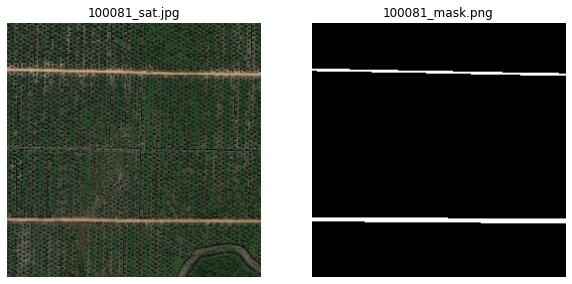

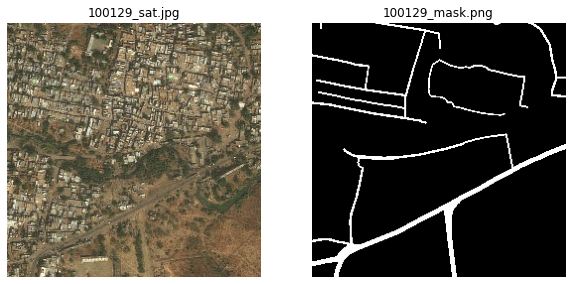

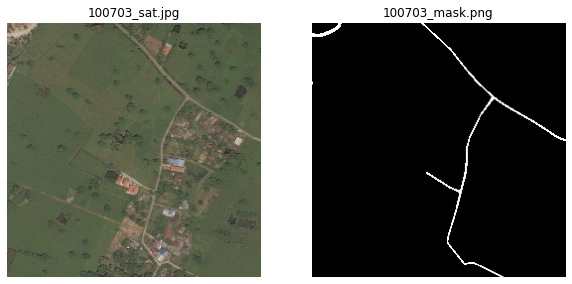

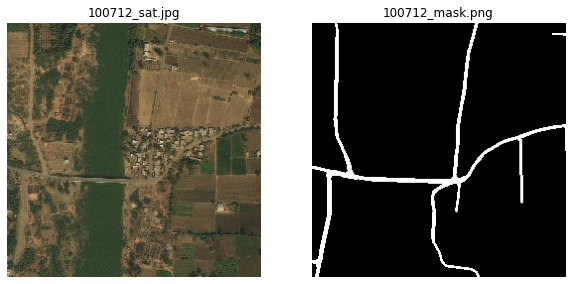

In [ ]:
display_images(df=df, split_val='train', data_path='/content/DeepGlobe_256/', show_plot=True)

#### 3.8.2. Valid Images

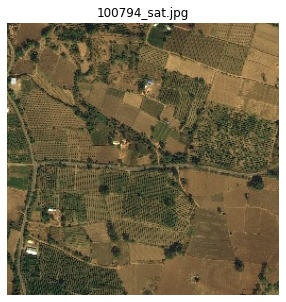

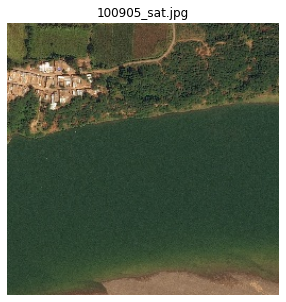

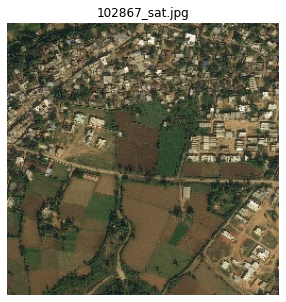

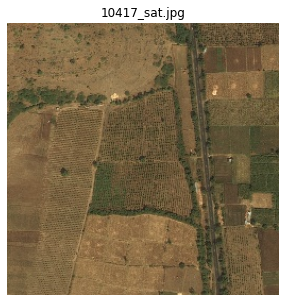

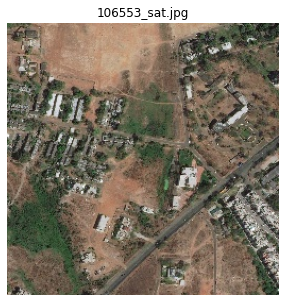

In [ ]:
display_images(df=df, split_val='valid', data_path='/content/DeepGlobe_256/', show_plot=True)

#### 3.8.3. Test Images

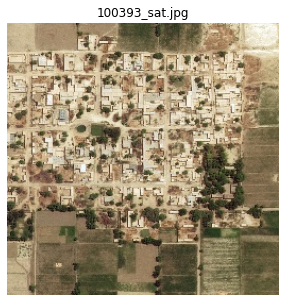

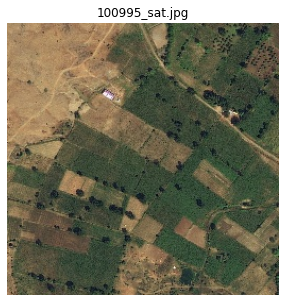

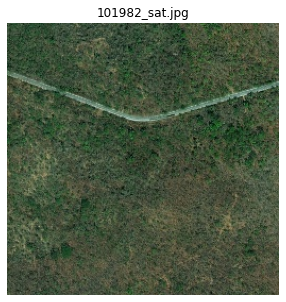

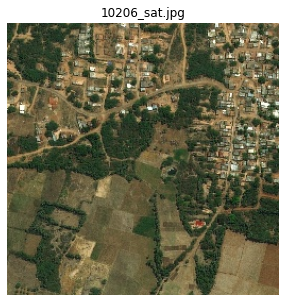

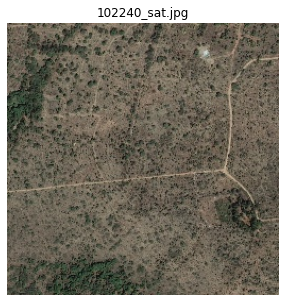

In [ ]:
display_images(df=df, split_val='test', data_path='/content/DeepGlobe_256/', show_plot=True)

## 4. Conclusion

Steps

* First, the original data is loaded.
* The training data (masks) are successfully binarized.
* The image sets (train, valid, test) are resized to the size of `(256, 256, 3)`. This is to make sure the sizes of the images are same.
* Whole data is saved in the drive to avoid continuous repetition of code execution.